# Pycel_sensitivity tutorial
Pycel_sensitivity is a wrapper around the package pycel (https://github.com/dgorissen/pycel).  Pycel is "a small python library that can translate an Excel spreadsheet into executable python code which can be run independently of Excel."  The Pycel package allows a user to run a spreadsheet in python.  

Pycel_sensitivity provide wrappers for common needs, such as identifing input and output variables, tracking variable names and units, repeating calculations from a list if input variables, drawing repeated calculations from probability distributions, summarizing results in dataframes or histograms.  

## Imports

In [1]:
# If in colab
!pip install pycel

     |████████████████████████████████| 114 kB 8.2 MB/s 
     |████████████████████████████████| 109 kB 12.6 MB/s 
     |████████████████████████████████| 546 kB 38.8 MB/s 


In [2]:
import pycel
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
!git clone https://github.com/gbrunkhorst/pycel_sensitivity.git
!pwd
cd pycel_sensitivity
import pycel_sensitivity as pcs

Cloning into 'pycel_sensitivity'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


# Compile and Calculate a Spreadsheet with `Pycel`
A cost estimating worksheet is used for this example.  A cost estimate is something that an engineer is unlikely to port over to python, for collaboration with non-coders and for visual checking.  However, the repetitive components can be improved with `pycel`. The following code shows the basic functionality of pycel. 

First, compile the example spreadsheet.  

In [11]:
filename = "Cost_Estimate_Example.xlsx"
wb = pycel.ExcelCompiler(filename=filename)

`wb` is the compiled Excel workbook, which will be used in the rest of this tutorial.  With `pycel`, we can access values using the method `evaluate`.  Assume that an input cell of interest is as follows:     

In [12]:
sheet = 'Sheet1'
input_cell = 'E5'
wb.evaluate(sheet+'!'+input_cell)

100000

And an output cell of interest is as follows:

In [13]:
output_cell = 'F11'
wb.evaluate(sheet+'!'+output_cell)

21462000

We can modify the input cell with `set_value`.

In [14]:
value = 50000
wb.set_value(sheet+'!'+input_cell, value)
wb.evaluate(sheet+'!'+input_cell)

50000

Now the output cell has changed as well - following the calculation logic in the spreadsheet.  

In [15]:
wb.evaluate(sheet+'!'+output_cell)

11662000.0

That is the basic calculation functionality of pycel!  If you want to repeat a calculation a bunch of times, you could put the functions in a loop, which is more/less what `pycel_sensitivity` does for you.  `pycel_sensitivity` will help track inputs and outputs as a list of values run sequentially, a list of values run randomly as monte carlo, and probability distributions as monte carlo.      

# `Pycel_sensitivity` with a List of Inputs
`Pycel_sensitivity` has three classes, `InputVar` for input variables, `OutputVar` for output variables, and `Model` for the combined spreadsheet model, variables, and convenience functions.  Working from the example above, lets assume that you want to run the calculation with a list of input values. This shows a basic workflow for repetive calculations.  

## One Input and One Output Variable

In [16]:
# Specify a list on inputs
values = [50000, 100000, 200000]
# Instanciate the `InputVar` with the compiled workbook, sheet, cell, and list of values
iv = pcs.InputVar(wb, sheet, input_cell, values = values )
# Same for `OutputVar`. 
ov =  pcs.OutputVar(wb, sheet, output_cell)
# Instanciate the `Model` object with pycel compiled workbook and lists on InputVars and OutputVars.  
model = pcs.Model(wb,[iv],[ov])
# Run the model to perform the calculation on all input values in the list.
model.run()
# Get the results into a dataframee
model.get_io_values()

,Inputs,Outputs
,E5,F11
0,50000,11662000.0
1,100000,21462000.0
2,200000,41062000.0


## Multiple Inputs and Outputs with Names and Units
This section shows how `Model` handles multiple inputs and outputs, and additional attributes of `InputVar` and `OutputVar` for tracking and table and figure labeling.

In [17]:
# Now we give the input variable a name and unit for convenience
iv1 = pcs.InputVar(wb,sheet=sheet, cell=input_cell, 
    name='Dredging Quantity', unit = 'cy', values = values)

# Second input  - list must be of the same length
values = [15, 20, 25]
iv2 = pcs.InputVar(wb,sheet=sheet, cell='C4', 
    name='Dredging Unit Cost', unit = '$/cy', values = values  )

# Specify two output variables
ov1 = pcs.OutputVar(wb,sheet = sheet, cell = 'F5' ,name= 'Dredging Cost', unit = '$' )
ov2 = pcs.OutputVar(wb,sheet = sheet, cell = 'F11' ,name= 'Project Cost', unit = '$' )

# Instanciate and run the model
model = pcs.Model(wb,[iv1, iv2],[ov1, ov2])
model.run()

# the output dataframe includes the names
model.get_io_values()

Inputs                          Outputs             
  Dredging Quantity Dredging Unit Cost Dredging Cost Project Cost
0             50000                 15       1000000   11200021.0
1            100000                 20       2000000   21000028.0
2            200000                 25       4000000   40600035.0

The model is run for each pair of inputs sequentially.  

# `Pycel_sensitivity` with Randomly Drawn Inputs
The model can be used to run a monte carlo simulation iterately with random draws from the list of input values.  If we supply the keyword `iterations` with an integer, the model will perform the monte carlo simulation using `np.random.choice` rather than running the list of inputs sequentially.   


In [18]:
model.run(iterations = 1000)

The `describe` method provides summary statistics.  

In [19]:
model.describe()

,sheet,cell,type,unit,count,mean,std,min,10%,50%,90%,max
Dredging Quantity,Sheet1,E5,input,cy,1000.0,1.170000e+05,6.164252e+04,50000.0,50000.0,100000.0,200000.0,200000.0
Dredging Unit Cost,Sheet1,C4,input,$/cy,1000.0,1.976500e+01,4.054160e+00,15.0,15.0,20.0,25.0,25.0
Dredging Cost,Sheet1,F5,output,$,1000.0,2.340000e+06,1.232850e+06,1000000.0,1000000.0,2000000.0,4000000.0,4000000.0
Project Cost,Sheet1,F11,output,$,1000.0,2.433203e+07,1.208193e+07,11200021.0,11200021.0,21000028.0,40600028.0,40600035.0


# `Pycel_sensitivity` with Inputs as `Scipy.Stats` Probability Distributions
The next logical extension is to use continuous probability distributions as inputs rather than discrete distributions.  `pycel_sensitivity` accepts `scipy.stats` continuous probability distributions as inputs to the monte carlo analysis.  See https://docs.scipy.org/doc/scipy/reference/stats.html for available distributions.  

In [20]:
# normal distribution
dist1  = ss.norm(100000,20000)
# uniform distribution 
# (note that the second parameter 
# is the width rather than the max!)
dist2 = ss.uniform(15, 10)

In [21]:
# reinstanciate the input variable and the model
iv1 = pcs.InputVar(wb,sheet=sheet, cell=input_cell, 
    name='Dredging Quantity', unit = 'cy', dist = dist1)
iv2 = pcs.InputVar(wb,sheet=sheet, cell='C4', 
    name='Dredging Unit Cost', unit = '$/cy', dist=dist2)

model = pcs.Model(wb,[iv1, iv2],[ov1, ov2])

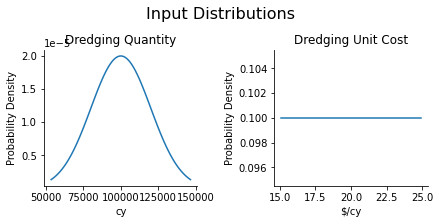

In [22]:
# check the input distributions
model.plot_input_dists();

In [23]:
model.run(iterations = 1000)

In [24]:
model.describe()

,sheet,cell,type,unit,count,mean,std,min,10%,50%,90%,max
Dredging Quantity,Sheet1,E5,input,cy,1000.0,1.004589e+05,1.989654e+04,3.176938e+04,7.636015e+04,9.966147e+04,1.257515e+05,1.651907e+05
Dredging Unit Cost,Sheet1,C4,input,$/cy,1000.0,1.998482e+01,2.886487e+00,1.500063e+01,1.607192e+01,2.005114e+01,2.395573e+01,2.499523e+01
Dredging Cost,Sheet1,F5,output,$,1000.0,2.009177e+06,3.979308e+05,6.353877e+05,1.527203e+06,1.993229e+06,2.515029e+06,3.303815e+06
Project Cost,Sheet1,F11,output,$,1000.0,2.108997e+07,3.899722e+06,7.626823e+06,1.636662e+07,2.093368e+07,2.604731e+07,3.377741e+07


The results can also be plotted with the `plot_hists()` convenience function.  

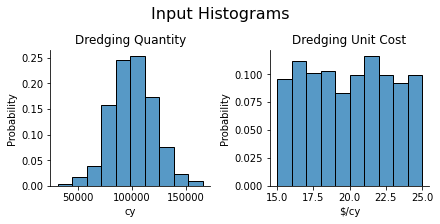

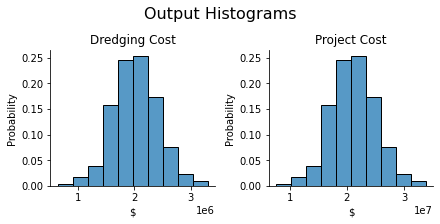

In [25]:
model.plot_hists('input'), model.plot_hists('output');

# Returning `matplotlib` and `pandas` Objects
The default summary tables and figures might not be good for your purposes.  In that case, you can return the base objects and work with them in python. 

Modify the default graphics with `matplotlib`.

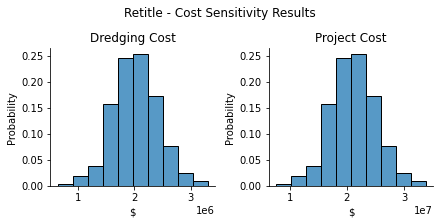

In [26]:
axes = model.plot_hists('output')
plt.suptitle('Retitle - Cost Sensitivity Results');

`get_io_values` returns all the monte carlo results if you want to manipulate them yourself.  

In [27]:
results = model.get_io_values('output')
results.head()

,Dredging Cost,Project Cost
0,2.404134e+06,2.496055e+07
1,2.581706e+06,2.670075e+07
2,1.943201e+06,2.044340e+07
3,1.629030e+06,1.736453e+07
4,1.580115e+06,1.688516e+07


Make your own graphic.  

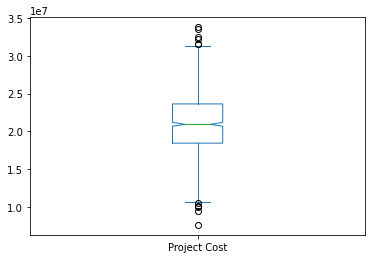

In [28]:
results['Project Cost'].plot.box(notch=True)